In [1]:
import numpy as np
from matplotlib.pyplot import get_cmap
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
from boston_ds import BostonDS
from drift_detection.drift_testers.ks_drift_tester import KsDriftTester
from helpers.data_helper import sample_from_data
from helpers.model_helper import XgbModel
from helpers.utils import calc_perf_kpis

from drift_detection.drift_detector import DriftDetector


### Prepare Boston data for demo

In [2]:

# ============================================================= Initial data setup
# Load and prep boston data
boston = BostonDS()

x = boston.x
y = boston.y
x_cont_features = boston.cont_features
x_int_features = boston.int_features
x_cat_features = boston.cat_features

# from entire dataset, choose subset for initial train/test
TRAIN_TEST_SIZE = 520
x_sample, y_sample = sample_from_data(x, y, TRAIN_TEST_SIZE)
x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size=0.4, random_state=10)


### Initial model train

In [3]:

# ============================================================= Train step

# Build model on train data
model = XgbModel()
model.fit(x_train, y_train)

# predict y on test data
y_pred = model.predict(x_test)

### Initial drift detector configuration and train

In [8]:
# Create Feature drift detector with all default testers
drift_detector = DriftDetector()
drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
drift_detector.fit(x_train)

# initial drift test - initial test vs train
drift_test_results = drift_detector.test_drift(x_test)


### Collect data for plots later

In [5]:

# Calc and store initial model performance KPIs on test
kpi = calc_perf_kpis(x_test, y_test, y_pred)
kpi['drift_detected'] = drift_test_results['drift_detected']
kpi['test_exceptions'] = drift_test_results['test_exceptions']

perf_kpis = pd.DataFrame(columns=kpi.keys()).append(kpi, ignore_index=True)

### Runtime step

In [6]:
# ============================================================= Runtime step
number_of_batches = 300
start_drift_at_batch = 100
sample_size = 50


# Runtime loop
for i in range(number_of_batches):
    # Sample batch from data (No drift yet)
    x_sample, y_sample = sample_from_data(x, y, sample_size)

    # modify data batch to create feature drift
    if i > start_drift_at_batch:
        x_sample['RM'] = x_sample['RM'] + x['RM'].std() * 0.01 * (i - start_drift_at_batch)
        x_sample['LSTAT'] = x_sample['LSTAT'] + x['LSTAT'].std() * 0.01 * (i - start_drift_at_batch)

    # predict
    y_pred = model.predict(x_sample)

    # calc RMSE (For demo only, cannot do in real runtime - no labels there
    kpi_sample = calc_perf_kpis(x_sample, y_sample, y_pred)

    # Execute drift test
    drift_test_results = drift_detector.test_drift(x_sample)

    kpi_sample['drift_detected'] = drift_test_results['drift_detected']
    kpi_sample['test_exceptions'] = drift_test_results['test_exceptions']
    perf_kpis = perf_kpis.append(kpi_sample, ignore_index=True)


### Plot RMSE and detection results

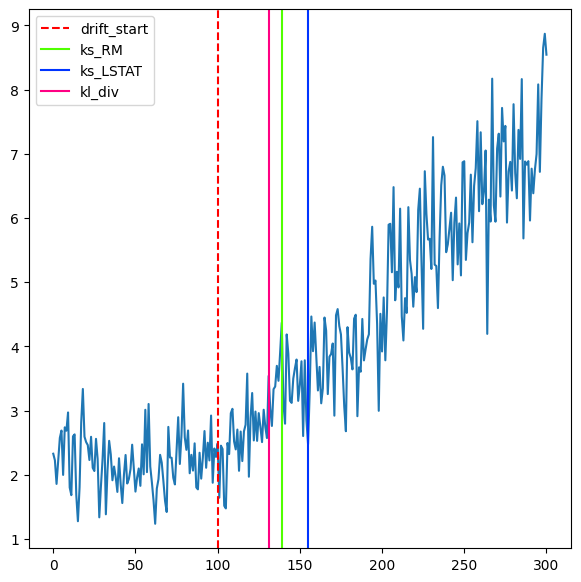

,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions
0,0.939984,0.935962,1.506796,1.506796,2.328533,False,[]
1,0.925932,0.899185,1.401480,1.401480,2.226613,False,[]
2,0.967346,0.955554,1.133477,1.133477,1.858410,False,[]
3,0.939992,0.918322,1.245769,1.245769,2.213718,False,[]
4,0.945000,0.925138,1.452252,1.452252,2.574912,False,[]
...,...,...,...,...,...,...,...
296,0.543679,0.378897,5.232575,5.232575,6.717812,True,"[ks_RM, ks_LSTAT, kl_div]"
297,0.290492,0.034280,6.482465,6.482465,7.854649,True,"[ks_RM, ks_LSTAT, kl_div]"
298,0.184585,-0.109870,6.470568,6.470568,8.648507,True,"[ks_RM, ks_LSTAT, kl_div]"
299,0.166383,-0.134645,7.131327,7.131327,8.867980,True,"[ks_RM, ks_LSTAT, kl_div]"


In [7]:

# ========================================================================== Plot

fig, axs = plt.subplots(figsize=(7, 7))

# plot RMSE (Loss function) line
axs.plot(perf_kpis['RMSE'])

# plot vertical lin for data drift start point
axs.axvline(x=start_drift_at_batch, label='drift_start', color='r', linestyle='dashed')

# Get drift detector x_history for plots
x_history = drift_detector.history_df

# plot vertical line for each tester that fired
fail_detections = []
cmap = get_cmap('hsv', 15)

for i, test_name in enumerate(drift_detector.get_test_names()):
    if x_history[test_name].sum() > 0:
        detection_time = np.where(x_history[test_name] == True)[0].min()
        axs.axvline(x=detection_time, label=test_name, color=cmap(i))

# Display plot
axs.legend()
plt.show()

display(perf_kpis)
